In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pylab as plt 

In [2]:
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

# Illustrate LHS with Inducing Points

In [3]:
lhs_1 = pd.read_csv('data/lhs_16.csv', index_col=0)
lhs_2 = pd.read_csv('data/lhs_4.csv', index_col=0)

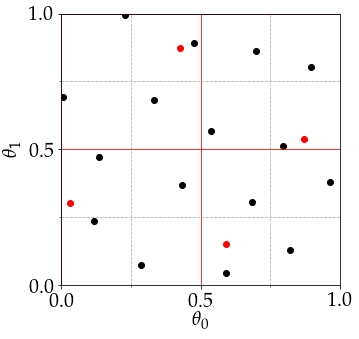

In [4]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(lhs_1['V1'], lhs_1['V2'], marker = 'o', c = 'k')
ax.scatter(lhs_2['V1'], lhs_2['V2'], marker = 'o', c = 'r')
ax.set_yticks(np.linspace(0.0, 1.0, 3), minor=False)
ax.set_yticks(np.linspace(0.0, 1.0, 5), minor=True)
ax.set_xticks(np.linspace(0.0, 1.0, 3), minor=False)
ax.set_xticks(np.linspace(0.0, 1.0, 5), minor=True)
ax.yaxis.grid(True, which='major', linestyle = '-', c = 'r')
ax.yaxis.grid(True, which='minor', linestyle = '--')
ax.xaxis.grid(True, which='major', linestyle = '-', c = 'r')
ax.xaxis.grid(True, which='minor', linestyle = '--')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
plt.ylabel(r'$\theta_{1}$', fontsize = fontSize)
plt.xlabel(r'$\theta_{0}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

# Testing SVGP

In [ ]:
# inputs =  torch.from_numpy(lhs_1.values)
# inducing = torch.from_numpy(lhs_2.values)
# yvals = torch.sin(inputs[:,0]) * torch.cos(inputs[:,1])

# Testing Bayesian Committee Machine

In [1]:
import torch
import matplotlib.pylab as plt 
from src.gp.bcm import clustering, distance_from_cluster
from src.gp.kernel import compute_kernel
from src.gp.bcm import log_marginal_likelihood, cost
from src.gp.bcm import BayesianMachine

In [2]:
ndata = 25
inputs = torch.rand(ndata, 2) # torch.from_numpy(lhs_1.values)
yvals = inputs[:,0] * torch.cos(inputs[:,1])

### Test Clustering

In [3]:
module, record = clustering(inputs, yvals, 3)
pred_labels = distance_from_cluster(module, torch.Tensor([0.7, 0.5]))

### Test Evidence Calculation

In [4]:
hyper = torch.Tensor([0.0, 0.0, 0.0])

In [5]:
kernel = compute_kernel(inputs, inputs, hyper)

In [8]:
log_marginal_likelihood(kernel, yvals, 1E-5)

tensor([98.0708])

In [9]:
kernel1 = compute_kernel(record['0'][0], record['0'][0], hyper)
kernel2 = compute_kernel(record['1'][0], record['1'][0], hyper)
kernel3 = compute_kernel(record['2'][0], record['2'][0], hyper)

In [10]:
z1 = log_marginal_likelihood(kernel1, record['0'][1], 1E-5)
z2 = log_marginal_likelihood(kernel2, record['1'][1], 1E-5)
z3 = log_marginal_likelihood(kernel3, record['2'][1], 1E-5)

In [11]:
z1 + z2 + z3

tensor([70.9662])

### Test Multiprocessing

In [12]:
arguments = [[kernel1, record['0'][1], 1E-5], [kernel2, record['1'][1], 1E-5], [kernel3, record['2'][1], 1E-5]]

In [13]:
from torch.multiprocessing import Pool, Process, set_start_method
try:
     set_start_method('spawn')
except RuntimeError:
    pass

In [14]:
from src.gp.bcm import log_marginal_likelihood_parallel

In [21]:
# we can use this to find number of cpus available
nprocesses = torch.multiprocessing.cpu_count()

In [15]:
multi_pool = Pool(processes=3)
log_mls = multi_pool.map(log_marginal_likelihood_parallel, arguments)
multi_pool.close() 
multi_pool.join()

In [19]:
torch.FloatTensor(log_mls).sum(0)

tensor(70.9662)

### Test Evidence Function

In [10]:
cost(record, hyper, 1E-5)

tensor([71.1676])

### Test the Main Code

In [11]:
bcm_kmeans = BayesianMachine(inputs, yvals, 1E-5, n_clusters = 2)
bcm_exact = BayesianMachine(inputs, yvals, 1E-5)

In [12]:
d_kmeans = bcm_kmeans.optimisation(hyper, 3000, 0.001, 2)
d_exact = bcm_exact.optimisation(hyper, 3000, 0.001, 2)

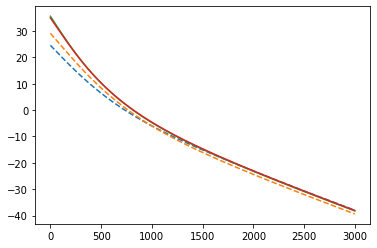

In [13]:
plt.figure()
plt.plot(d_kmeans[0]['loss'], linestyle = '--')
plt.plot(d_kmeans[1]['loss'], linestyle = '--')
plt.plot(d_exact[0]['loss'], linestyle = '-')
plt.plot(d_exact[1]['loss'], linestyle = '-')
plt.show()

In [14]:
d_kmeans[0]['parameters']

tensor([ 3.2434, -1.9942, -1.7066])

In [15]:
d_kmeans[1]['parameters']

tensor([ 3.3996, -1.8750, -1.5794])

In [16]:
d_exact[0]['parameters']

tensor([ 3.3424, -1.6965, -1.5520])

In [17]:
d_exact[1]['parameters']

tensor([ 3.3211, -1.6704, -1.6117])